# Integrating under a filter curve with `gollum`

Synthetic photometry is common technique to compare the predicted flux in a given astronomical filter to the observed flux seen in images.  Here we show how to generate synthetic photometry.

In [1]:
from gollum.phoenix import PHOENIXGrid, PHOENIXSpectrum
from specutils import Spectrum1D
import pandas as pd
import astropy.units as u
import numpy as np
from urllib.error import URLError

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

## Fetch the filter curve

In [2]:
tess_filter_curve_website = 'https://heasarc.gsfc.nasa.gov/docs/tess/data/tess-response-function-v1.0.csv'
local_file = 'tess-response-function-v1.0.csv'

In [3]:
# try to directly read from the website first, if not then download the file locally
try:
    tess_response = pd.read_csv(tess_filter_curve_website, skiprows=8, names=['wl_nm', 'transmission'])
except URLError:
    tess_response = pd.read_csv(local_file, skiprows=8, names=['wl_nm', 'transmission'])

In [4]:
tess_response

,wl_nm,transmission
0,454.050074,0.000000
1,463.770250,0.000000
2,472.606775,0.000000
3,507.069219,0.000000
4,536.229750,0.000000
...,...,...
174,1101.806290,0.025735
175,1109.746167,0.016912
176,1115.921987,0.010294
177,1122.978212,0.001471


In [5]:
filter_curve = Spectrum1D(spectral_axis=tess_response.wl_nm.values*u.nm, 
           flux=tess_response.transmission.values*u.dimensionless_unscaled)

to be continued...

In [6]:
spec1 = PHOENIXSpectrum(path='../../../data/phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/',
                       wl_lo=4000, wl_hi=12000, teff = 5700, logg = 4, metallicity = 0)
spec2 = PHOENIXSpectrum(path='../../../data/phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/',
                       wl_lo=4000, wl_hi=12000, teff = 4200, logg = 4, metallicity = 0)

In [7]:
resampled_spec1 = spec1.instrumental_broaden(resolving_power=300).resample(filter_curve)
resampled_spec2 = spec2.instrumental_broaden(resolving_power=300).resample(filter_curve)

In [8]:
normalization_scalar = np.percentile(resampled_spec1.flux, 95)

In [9]:
normalized_spec1 = resampled_spec1.divide(normalization_scalar)
normalized_spec2 = resampled_spec2.divide(normalization_scalar)

(0.0, 1.25)

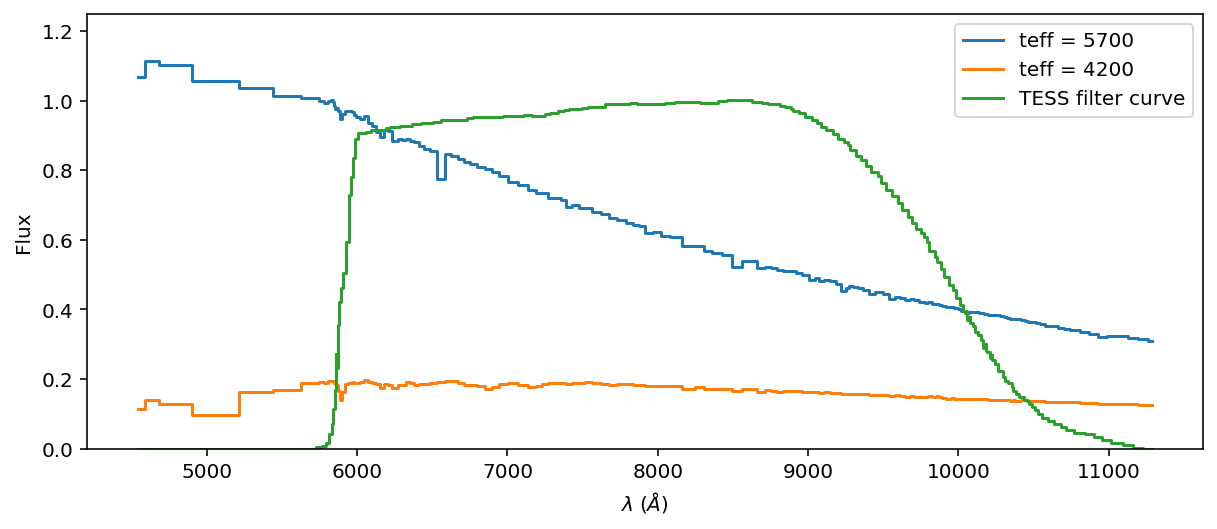

In [10]:
ax = normalized_spec1.plot(label='teff = 5700')
normalized_spec2.plot(ax=ax, label='teff = 4200')
ax.step(filter_curve.wavelength, filter_curve.flux, label='TESS filter curve');
ax.legend()
ax.set_ylim(0, 1.25)

Yay! We overplotted the filter curve and the stellar spectrum. The filter was coursely sampled, which is acceptable for most applications.

In [11]:
area_under_the_curve1 = np.sum(normalized_spec1.flux*filter_curve.flux)
area_under_the_curve2 = np.sum(normalized_spec2.flux*filter_curve.flux)
ratio = area_under_the_curve2/area_under_the_curve1
ratio

<Quantity 0.26478967>